In [70]:
import pandas as pd
import numpy as np 
import glob
import os 
import re
import pickle
from clustereval import stability, purity
import plotnine as pn
import operator
import functools
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
os.chdir('/data/swamyvs/scEiad_subcelltype')

In [2]:
exp_files = glob.glob("clustering_out/*/*.csv.gz", recursive=True)
with open("testing/exp_stab_df_list_full_try4_noperturb.pck", 'rb') as ofl:
    all_stability_calcs = pickle.load(ofl)
with open("testing/exp_purity_df_list_full_try4_noperturb.pck", 'rb') as ofl:
    all_purity_calcs= pickle.load(ofl)
barcode_2batch = pd.read_csv('amacrine_mm_barcode2batch.csv.gz')
exp_meta_df = pd.DataFrame([re.split("_|-|/", x.split('out/')[1])[::2] for x in exp_files],
                           columns=['clustering_type', 'experiment', 'dist', 'knn']).assign(path=exp_files)
cluster_output =  [(pd
                      .read_csv(i)
                      .merge(barcode_2batch, how = 'inner')
                      .assign(labels=lambda x: 'clu_' + x.labels.astype(str))
                     ) for i in exp_files]

In [3]:
exp_meta_df_exp_raw = exp_meta_df[['clustering_type', 'experiment', 'dist', 'knn']].agg('-'.join, axis=1).to_list()

cluster_output_tup_dfs = list(zip(exp_meta_df_exp_raw, cluster_output))
stab_tup_dfs = [(df.columns[0], df) for df in all_stability_calcs]
purity_tup_dfs = [(df.columns[2], df) for df in all_purity_calcs]

cluster_output_tup_dfs.sort(key = operator.itemgetter(0))
stab_tup_dfs.sort(key = operator.itemgetter(0))
purity_tup_dfs.sort(key = operator.itemgetter(0))


In [4]:
def batch_score(exp, nbatch): # both are dfs with 3 columsn, Barcode, cluster,batch
    # calc H_tot
    res = (exp
             .groupby("labels")
             .agg({'Barcode': 'count', 'batch':'nunique' })
             .reset_index(drop=False)
             .assign(prop=lambda x: x['Barcode']/exp.shape[0],
                     weighted_nstudies=lambda x: x['prop'] * x['batch'] / nbatch)
             .rename(columns = {'batch':'nstudies', 'Barcode' :'ncells'})) 
    
    return res

nbatch = barcode_2batch.batch.nunique()



def merge_dfs(cluster, stab, purity, exp):
    cluster = batch_score(cluster, nbatch).sort_values('labels').assign(experiment = exp)
    stab.columns = ['labels', 'stability']
    purity.columns = ['purity',	'n_exp_evaluated',	'labels']
    stab = stab.sort_values('labels')
    purity = purity.sort_values('labels')
    assert sum(stab['labels'] == purity['labels'] ) == sum(stab['labels'] == cluster['labels']) 
    return pd.concat([cluster, 
                      stab.drop(columns= ['labels']), 
                      purity.drop(columns = ['labels'])],  axis = 1)


all_experiments_results_list =  [
    merge_dfs(cluster_output_tup_dfs[i][1], stab_tup_dfs[i][1], purity_tup_dfs[i][1],cluster_output_tup_dfs[i][0])
    for i in range(len(cluster_output_tup_dfs))
]


In [6]:
all_experiments_results_df = pd.concat(all_experiments_results_list, axis = 0)

In [7]:
all_experiments_results_df[['alg', 'exp', 'res', 'knn']] = all_experiments_results_df.experiment.str.split('-', expand = True)

In [8]:
all_experiments_results_df = all_experiments_results_df.assign(knn = lambda x: x.knn.astype(int), 
                                                              res = lambda x: x.res.astype(float))

In [161]:
with open('testing/clusterEval_metric_results_v2.pickle', 'wb+') as ofl:
    pickle.dump((all_experiments_results_df, cluster_output_tup_dfs, purity_tup_dfs, stab_tup_dfs), ofl)

In [9]:
all_experiments_results_df.columns

Index(['labels', 'ncells', 'nstudies', 'prop', 'weighted_nstudies',
       'experiment', 'stability', 'purity', 'n_exp_evaluated', 'alg', 'exp',
       'res', 'knn'],
      dtype='object')

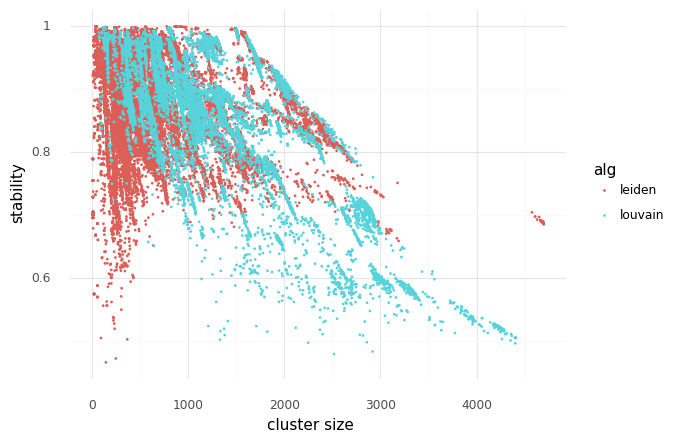

<ggplot: (2932041807056)>

In [10]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='ncells', y='stability', color = 'alg'), size = .1) +
    pn.xlab('cluster size') + 
    pn.theme_minimal()
)

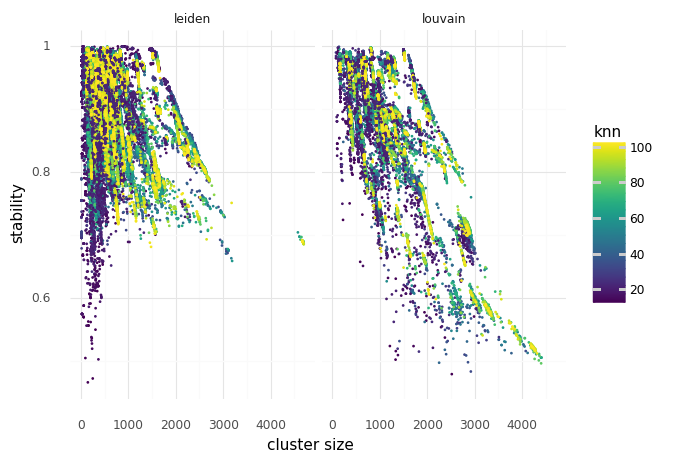

<ggplot: (2932705675499)>

In [14]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='ncells', y='stability', color = 'knn'), size = .1) +
    pn.xlab('cluster size') + 
    pn.facet_wrap('alg') + 
    pn.theme_minimal()
)

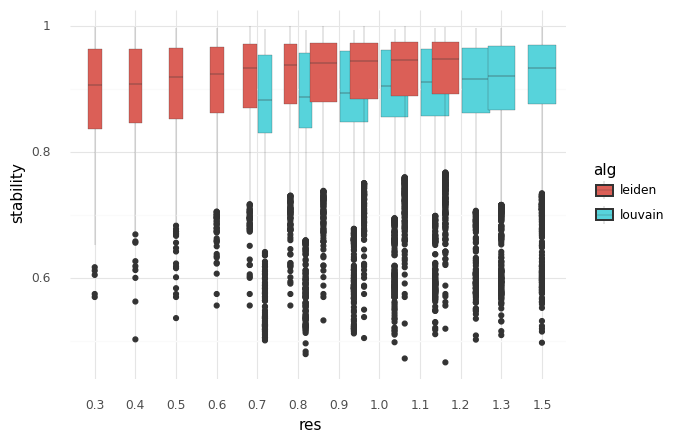

<ggplot: (2932701376296)>

In [19]:
(
    pn.ggplot(all_experiments_results_df.assign(res = lambda x: x.res.astype(str))) + 
    pn.geom_boxplot(pn.aes(x='res', y='stability', fill = 'alg'), size = .1) +
    pn.theme_minimal()
)

overall, Stability tends to decrease as cluster size increases. This makes sense, as larger clusters are likely to be broken into smaller ones across multiple runs 

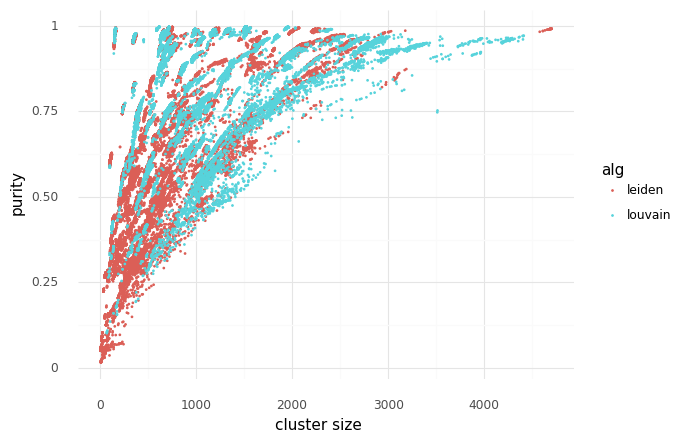

<ggplot: (2932702784657)>

In [45]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='ncells', y='purity', color = 'alg'), size = .1) +
    pn.xlab('cluster size') + 
    pn.theme_minimal()
)

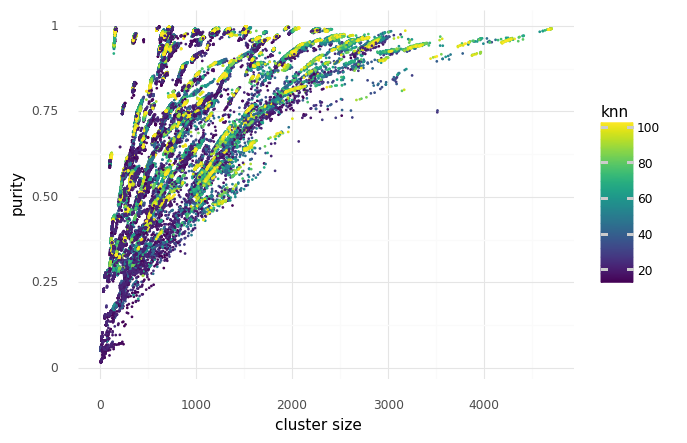

<ggplot: (2932703261275)>

In [61]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='ncells', y='purity', color = 'knn'), size = .1) +
    pn.xlab('cluster size') + 
    pn.theme_minimal()
)

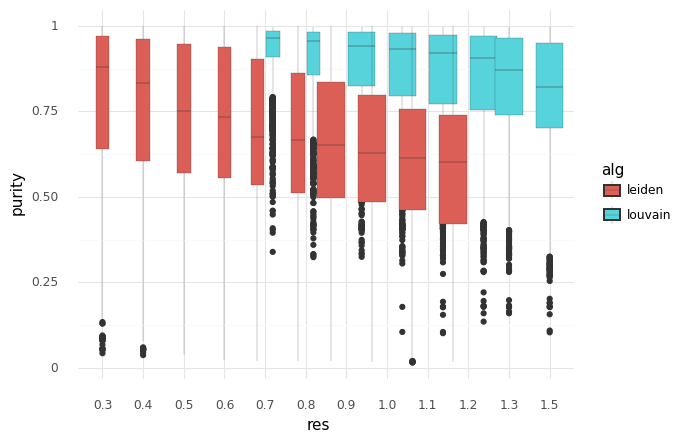

<ggplot: (2932711905850)>

In [18]:
(
    pn.ggplot(all_experiments_results_df.assign(res = lambda x: x.res.astype(str))) + 
    pn.geom_boxplot(pn.aes(x='res', y='purity', fill = 'alg'), size = .1) +
    pn.theme_minimal()
)

purity tends to increase as cluster size increases. This makes sense, because cells in larger cluster will tend to be found together in smaller clusters 

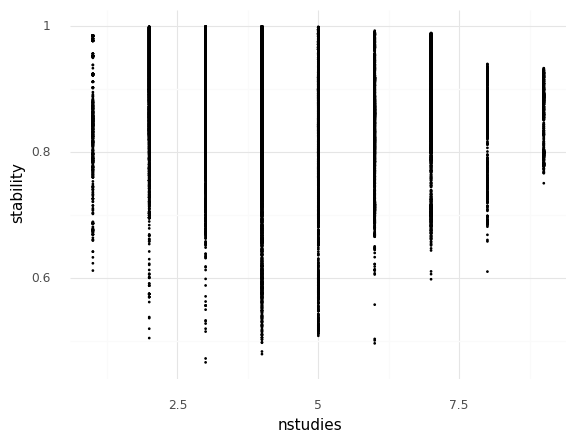

<ggplot: (2932702977603)>

In [36]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='nstudies', y='stability'), size = .1) +

    pn.theme_minimal()
)

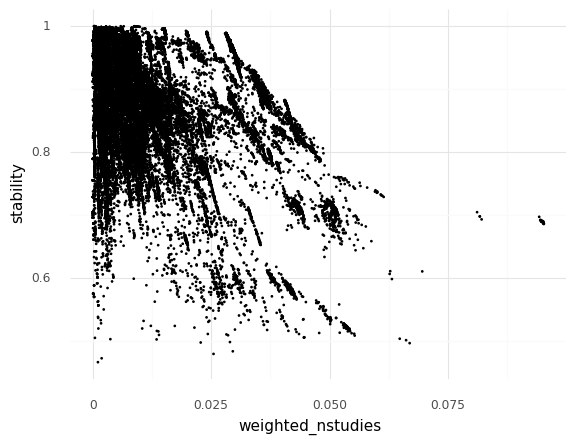

<ggplot: (2932715106079)>

In [47]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='weighted_nstudies', y='stability'), size = .1) + 
    pn.theme_minimal()
)

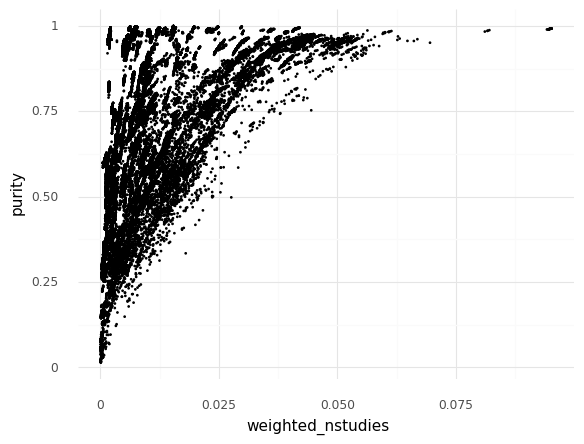

<ggplot: (2932703035423)>

In [48]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='weighted_nstudies', y='purity'), size = .1) +
    pn.theme_minimal()
)

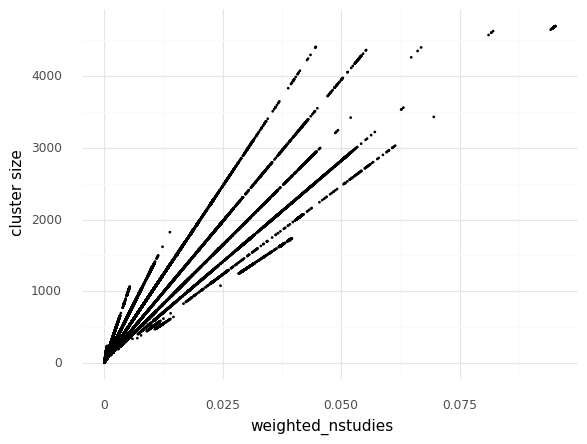

<ggplot: (2932702878121)>

In [39]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='weighted_nstudies', y='ncells'), size = .1) +
    pn.ylab('cluster size') + 
    pn.theme_minimal()
)

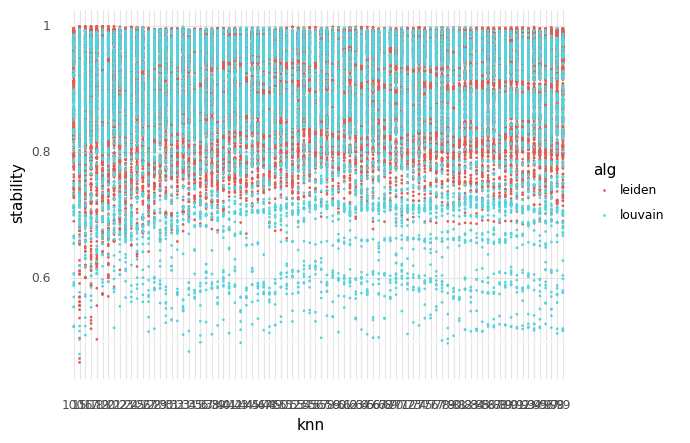

<ggplot: (2932720025604)>

In [49]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='knn', y='stability', color = 'alg'), size = .1) +
    pn.theme_minimal()
)

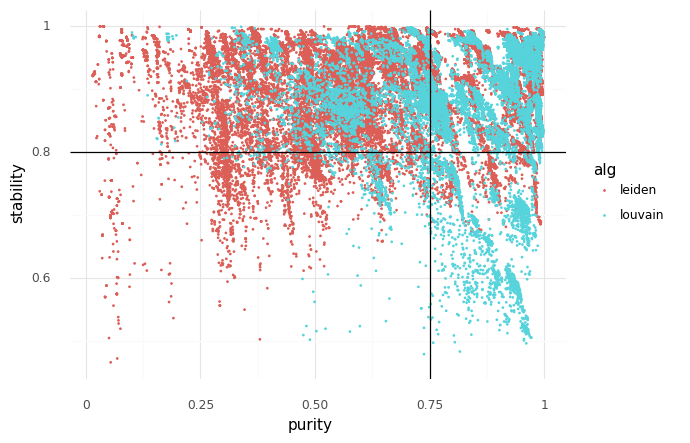

<ggplot: (2932706102510)>

In [21]:
(
    pn.ggplot(all_experiments_results_df) + 
    pn.geom_point(pn.aes(x='purity', y='stability', color = 'alg'), size = .1) +
        pn.geom_vline(xintercept = .75, color = 'black') +
    pn.geom_hline(yintercept = .8, color = 'black') +
    pn.theme_minimal()
)

In [188]:
all_experiments_summary_df = (all_experiments_results_df
                              .assign(hq_cluster =lambda x: (x['purity'] >=.75) & (x['stability'] >=.8))
                              .groupby('experiment')
                              .agg({'stability': ['mean', 'median'], 
                                    'purity': ['mean', 'median'],
                                    'labels':['count'],
                                    'hq_cluster':['sum']
                                   } ) )

In [190]:
all_experiments_summary_df

stability              purity           labels hq_cluster
                      mean    median      mean    median  count        sum
experiment                                                                
leiden-0-0.3-15   0.874484  0.892061  0.637692  0.676877     58         21
leiden-0-0.4-15   0.881679  0.900702  0.598979  0.595783     66         19
leiden-0-0.5-15   0.891296  0.912776  0.568187  0.587367     74         18
leiden-0-0.6-15   0.891068  0.914743  0.535915  0.564056     79         17
leiden-0-0.7-15   0.900873  0.921777  0.485549  0.512649     89         13
...                    ...       ...       ...       ...    ...        ...
louvain-9-1.0-24  0.890359  0.917115  0.826834  0.855518     39         25
louvain-9-1.1-24  0.894508  0.917754  0.790888  0.835536     42         24
louvain-9-1.2-24  0.905227  0.925747  0.775043  0.779347     45         23
louvain-9-1.3-24  0.903144  0.925646  0.765823  0.807069     44         22
louvain-9-1.5-24  0.907601  0.937377  0.731199  0.748703     48         21

[1548 rows x 6 columns]

In [191]:
all_experiments_summary_df =all_experiments_summary_df.reset_index(drop = False)
all_experiments_summary_df.columns = ['experiment', 'avg_stability', 'median_stability', 'avg_purity', 'median_purity', 'n_clusters', 'n_hqcluster' ]


In [192]:
all_experiments_summary_df[['alg', 'exp', 'res', 'knn']] = all_experiments_summary_df.experiment.str.split('-', expand = True)

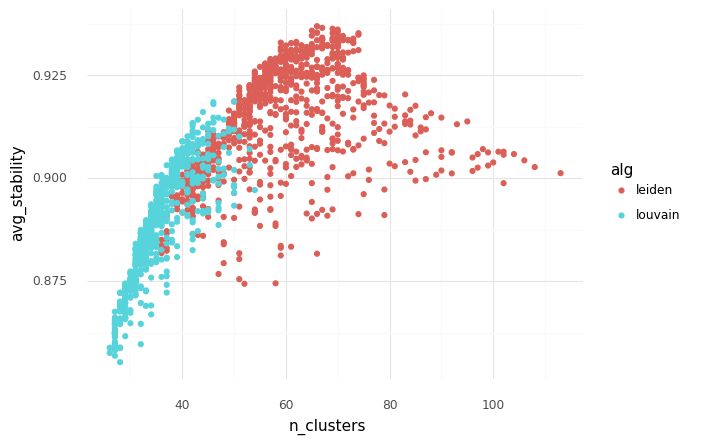

<ggplot: (2932706217427)>

In [193]:
(
    pn.ggplot(all_experiments_summary_df)+ 
    pn.geom_point(pn.aes(x='n_clusters', y='avg_stability', color = 'alg')) +
    pn.theme_minimal()
)

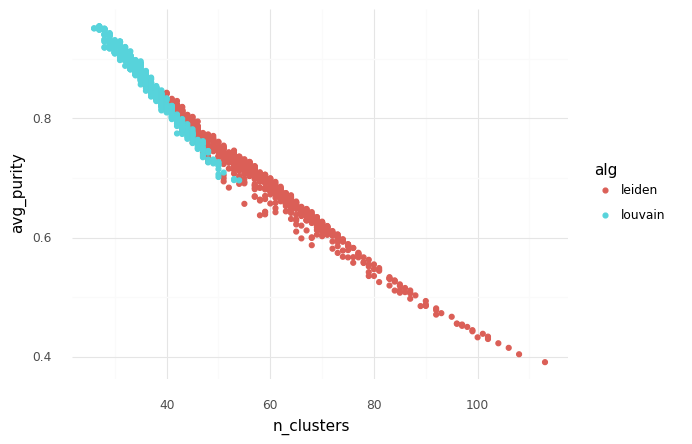

<ggplot: (2932712467149)>

In [194]:
(
    pn.ggplot(all_experiments_summary_df)+ 
    pn.geom_point(pn.aes(x='n_clusters', y='avg_purity', color = 'alg')) +
    pn.theme_minimal()
)

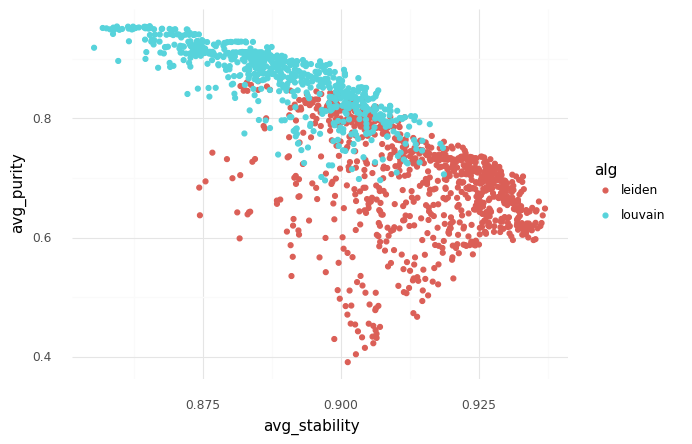

<ggplot: (2932713309371)>

In [195]:
(
    pn.ggplot(all_experiments_summary_df)+ 
    pn.geom_point(pn.aes(x='avg_stability', y='avg_purity', color = 'alg')) +
    pn.theme_minimal()
)

In [196]:
def center_scale(x):
    return (x-x.mean()) / x.std()

all_experiments_summary_df = all_experiments_summary_df.assign(avg_stability_cs = lambda x:center_scale(x['avg_stability']),
                                                               avg_purity_cs = lambda x: center_scale(x['avg_purity']),
                                                              sum_score = lambda x: x['avg_stability_cs'] +  x['avg_purity_cs'] )

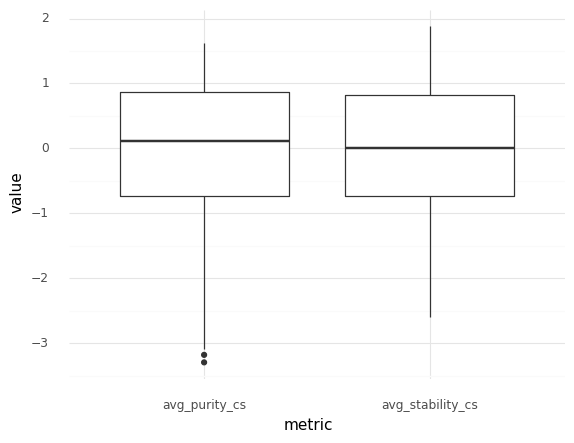

<ggplot: (2932701493125)>

In [197]:
(
    pn.ggplot(all_experiments_summary_df.melt(value_vars = ['avg_purity_cs', 'avg_stability_cs'], var_name = 'metric', value_name = 'value')) + 
    pn.geom_boxplot(pn.aes(x='metric', y='value')) + 
    pn.theme_minimal() 
)

In [201]:
co = all_experiments_summary_df.sort_values('sum_score', ascending=False).head(100).sum_score.min()
all_experiments_summary_df = all_experiments_summary_df.assign(alg_winners = lambda x: x.alg.where(~(x['sum_score']>=co), 'winner'))
print(all_experiments_summary_df.query('sum_score >=@co').sort_values('sum_score', ascending=False).iloc[:, 7:].to_string())

          alg exp  res  knn  avg_stability_cs  avg_purity_cs  sum_score alg_winners
495    leiden  53  0.8   68          1.660586      -0.579593   1.080994      winner
647    leiden  67  1.0   82          1.592267      -0.579492   1.012775      winner
625    leiden  65  0.8   80          1.336363      -0.328062   1.008301      winner
606    leiden  63  0.9   78          1.554087      -0.553874   1.000212      winner
517    leiden  55  1.0   70          1.653499      -0.659266   0.994232      winner
658    leiden  68  1.1   83          1.621877      -0.629913   0.991964      winner
646    leiden  67  0.9   82          1.381146      -0.393518   0.987628      winner
656    leiden  68  0.9   83          1.425140      -0.440550   0.984590      winner
604    leiden  63  0.7   78          1.274742      -0.301391   0.973351      winner
685    leiden  70  0.8   85          1.251873      -0.290496   0.961377      winner
684    leiden  70  0.7   85          1.242448      -0.289908   0.952541     

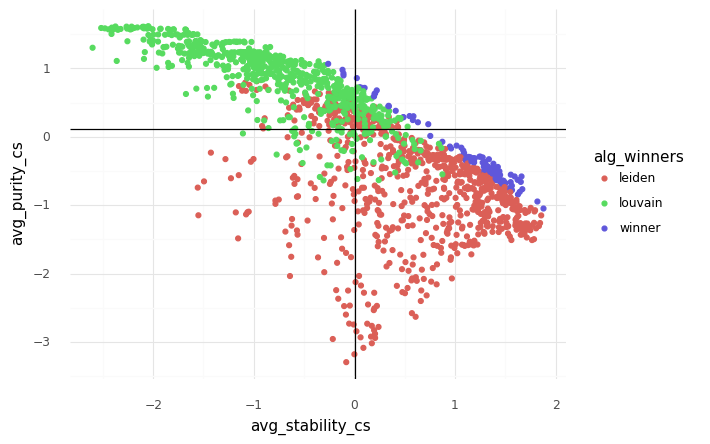

<ggplot: (2932714950834)>

In [202]:
(
    pn.ggplot(all_experiments_summary_df)+ 
    pn.geom_point(pn.aes(x='avg_stability_cs', y='avg_purity_cs', color = 'alg_winners')) +
    pn.geom_hline(yintercept =all_experiments_summary_df.avg_purity_cs.median() )+
    pn.geom_vline(xintercept =all_experiments_summary_df.avg_stability_cs.median() )+
    pn.theme_minimal()
)

In [211]:
def find_cutoffs(purity, stability, target, tol):
    upper_bound = 1
    lower_bound = .5
    iter_count = 0
    while True:
        iter_count+=1
        if iter_count > 100:
            print('Pick a higher tolerance')
            assert(1==2)            
        n_above = sum( (purity >purity.quantile(lower_bound)) & (stability >stability.quantile(lower_bound)) )
        target_diff = n_above - target
        if abs(target_diff) > tol:
            co_delta = upper_bound - lower_bound
            if target_diff > 0:
                lower_bound += co_delta/2
            elif target_diff < 0:
                upper_bound = lower_bound
                lower_bound -= co_delta/2
            else:
                print("SHOULD NOT BE HERE")
                assert(1 == 2)
        else:
            return lower_bound
    
new_co =find_cutoffs(all_experiments_summary_df['avg_purity_cs'],all_experiments_summary_df['avg_stability_cs'], 10, 0)

keep = all_experiments_summary_df.pipe(
    lambda x: (x['avg_purity_cs'] >= x.avg_purity_cs.quantile(new_co)) &(x['avg_stability_cs'] >= x.avg_stability_cs.quantile(new_co)) )
all_experiments_summary_df = all_experiments_summary_df.assign(alg_winners = lambda x: x.alg.where(~keep, 'winner'))

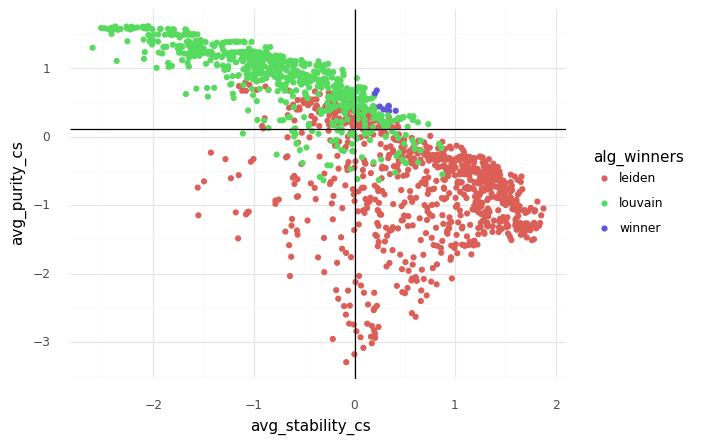

<ggplot: (2932716079050)>

In [212]:
(
    pn.ggplot(all_experiments_summary_df)+ 
    pn.geom_point(pn.aes(x='avg_stability_cs', y='avg_purity_cs', color = 'alg_winners')) +
    pn.geom_hline(yintercept =all_experiments_summary_df.avg_purity_cs.median() )+
    pn.geom_vline(xintercept =all_experiments_summary_df.avg_stability_cs.median() )+
    pn.theme_minimal()
)

In [80]:
batch_mixing_scores =  [ (adjusted_rand_score(x[1]['labels'], x[1]['batch']), 
                          normalized_mutual_info_score(x[1]['labels'], x[1]['batch']),
                          x[0])
                        for x in cluster_output_tup_dfs]


In [204]:
batch_mixing_scores_df = (pd
                          .DataFrame(batch_mixing_scores, columns = ['ari', 'nmi', 'experiment'])
                          .assign(ari_cs = lambda x: center_scale(x['ari']),
                                 nmi_cs = lambda x: center_scale(x['nmi']), 
                                 sum_batch_score = lambda x: x['ari_cs']*-1 + x['nmi_cs']*-1)
                         )

In [205]:
all_exp_sum_bm_df = all_experiments_summary_df.merge(batch_mixing_scores_df, how = 'inner').assign(bs_rank = lambda x: x.sum_batch_score.rank(ascending = False))

In [206]:
all_exp_sum_bm_df.sort_values('sum_batch_score', ascending = False).head(100)

,experiment,avg_stability,median_stability,avg_purity,median_purity,n_clusters,n_hqcluster,alg,exp,res,...,avg_stability_cs,avg_purity_cs,sum_score,alg_winners,ari,nmi,ari_cs,nmi_cs,sum_batch_score,bs_rank
9,leiden-0-1.2-15,0.901258,0.924399,0.391623,0.350693,113,6,leiden,0,1.2,...,-0.081297,-3.294848,-3.376145,leiden,0.015279,0.248386,-2.155403,-1.864808,4.020211,1.0
8,leiden-0-1.1-15,0.902735,0.925917,0.404861,0.349814,108,7,leiden,0,1.1,...,-0.000261,-3.179324,-3.179584,leiden,0.015565,0.249349,-2.117283,-1.772907,3.890191,2.0
19,leiden-1-1.2-16,0.904364,0.926207,0.415631,0.395539,106,7,leiden,1,1.2,...,0.089147,-3.085341,-2.996194,leiden,0.015520,0.250596,-2.123267,-1.653969,3.777236,3.0
129,leiden-2-1.2-17,0.906486,0.932738,0.432260,0.402903,102,7,leiden,2,1.2,...,0.205595,-2.940237,-2.734643,leiden,0.015650,0.250551,-2.105952,-1.658253,3.764205,4.0
18,leiden-1-1.1-16,0.905891,0.924715,0.423273,0.394063,104,7,leiden,1,1.1,...,0.172963,-3.018659,-2.845696,leiden,0.015945,0.250347,-2.066643,-1.677688,3.744331,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,leiden-17-1.0-32,0.921237,0.942578,0.604955,0.592641,72,17,leiden,17,1.0,...,1.015190,-1.433248,-0.418058,leiden,0.020813,0.254021,-1.417234,-1.327139,2.744372,96.0
728,leiden-74-1.1-89,0.928303,0.948966,0.699489,0.714645,59,21,leiden,74,1.1,...,1.402998,-0.608323,0.794674,winner,0.022835,0.251202,-1.147540,-1.596151,2.743691,97.0
858,leiden-9-1.1-24,0.916644,0.937946,0.526538,0.528231,84,14,leiden,9,1.1,...,0.763107,-2.117540,-1.354433,leiden,0.019893,0.255319,-1.540055,-1.203330,2.743385,98.0
229,leiden-29-1.2-44,0.934898,0.951298,0.596161,0.588673,74,18,leiden,29,1.2,...,1.764964,-1.509993,0.254971,leiden,0.021209,0.253489,-1.364451,-1.377949,2.742400,99.0


In [207]:
batch_co  = all_exp_sum_bm_df.sort_values('sum_batch_score', ascending = False).head(100).sum_batch_score.min()
all_exp_sum_bm_df = all_exp_sum_bm_df.assign(batch_winners = lambda x: x.alg.where(~(x['sum_batch_score']>=batch_co), 'winner'))

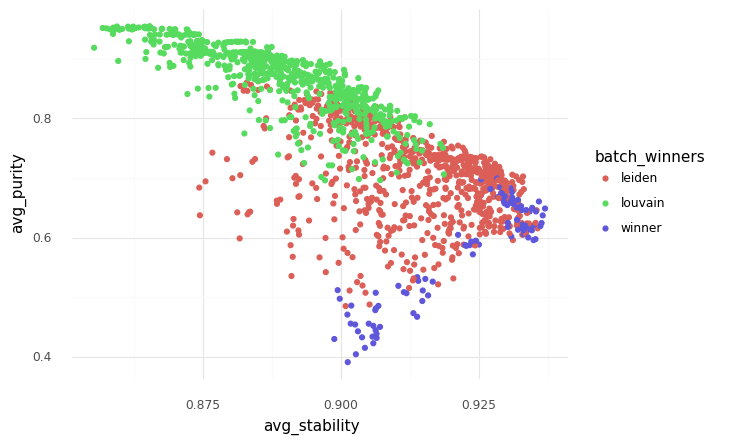

<ggplot: (2932714950783)>

In [208]:
(
    pn.ggplot(all_exp_sum_bm_df)+ 
    pn.geom_point(pn.aes(x='avg_stability', y='avg_purity', color = 'batch_winners')) +
    pn.theme_minimal()
)

In [209]:
np.corrcoef(all_exp_sum_bm_df['sum_batch_score'], all_exp_sum_bm_df['avg_purity'])

array([[ 1.        , -0.90405401],
       [-0.90405401,  1.        ]])

In [210]:
np.corrcoef(all_exp_sum_bm_df['sum_batch_score'], all_exp_sum_bm_df['avg_stability'])

array([[1.        , 0.91175174],
       [0.91175174, 1.        ]])